Module import

In [74]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [75]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y

Parameter

In [76]:
# 최대 x 범위 : 0 <= x < x_max, lambda 값
x_max = 2
x = tf.Variable(np.array([[i/100] for i in range(0, x_max * 100, 1)], dtype = np.float32))
lamb = -2

# 차수, weight 개수
n = 4
w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

# 변화 w 값, loss 저장
w_trace = []
w_trace.append(w.numpy())
loss_trace = []

#  학습률 조정
learning_rate = 0.01
# EPOCH = 100

# 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
Epoch = 0
target_loss = 0.001

# optimizer // tf.keras.optimizers.SGD, tf.keras.optimizers.Adam, etc.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

Model

In [88]:
# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y
    
class ODE_Predictor(tf.keras.Model):
    def __init__(self, w, n, lamb):
        super(ODE_Predictor, self).__init__()
        self.n = n
        self.lamb = lamb
        self.w = w

    def call(self, x):
        output = y(x, self.w, self.n)
        output = f(output, self.lamb)
        return output

n = 4
w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]
x_train = tf.Variable(np.array([[i/100] for i in range(0, x_max * 100, 1)], dtype = np.float32))
y_train = yprime(x_train, w, n)

Epochs = 10**4
LR = 0.001

model = ODE_Predictor(x, n, lamb)

def loss_opject(predict, y):
    return tf.math.sqrt(tf.square(predict, y))
    
optimizer = tf.keras.optimizers.SGD(learning_rate=LR)

from termcolor import colored

# epoch
for epoch in range(Epochs):
    dq = deque([1,2,3], 3)
    # iteration
    for x_val, y_val in zip(x_train, y_train):
        # Forward Propagation
        with tf.GradientTape() as tape:
            predict = model(x_val)
            loss = loss_opject(predict, y_val)
            loss_trace.append(loss.numpy())
            w_trace.append(w.numpy())
        dif = float(loss) < target_loss
        if dif and round(dq[0], 15) >= round(dq[2], 15):
            break
        # Back Propagation
        gradients = tape.gradient(loss, model.trainable_variables)
        # parameter update
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if dif and round(dq[0], 15) >= round(dq[2], 15):
        break
    if epoch % 1000 == 0:
        print(colored('Epoch : ', 'red'), epoch+1)
        template = 'Loss : {:.4f}\n'
        print(template.format(float(loss)))

print(Epoch, round(float(loss), 16))

TypeError: ODE_Predictor.call() missing 1 required positional argument: 'w'

Train

In [78]:
# # y' = f(y, t)를 만족하는 y 찾는 과정
# # 학습 과정
# while True:
#     Epoch += 1
#     dq = deque([1,2,3], 3)
#     for x_unit in x:
#         with tf.GradientTape() as tape:
#             # 예측 값
#             predict = f(y(x_unit, w, n), lamb)
#             # y' = f(y, t)
#             loss = tf.math.sqrt(tf.square(predict - yprime(x_unit, w, n)))
#             loss_trace.append(loss.numpy())
#             dq.append(float(loss))
#             # # 오차
#             w_trace.append(w.numpy())
#             # w = tf.Variable(w - learning_rate*gradients)
#         dif = float(loss) < target_loss
#         if dif and round(dq[0], 15) >= round(dq[2], 15):
#             break
#         gradients = tape.gradient(loss, w)
#         optimizer.apply_gradients(zip([gradients], [w]))
#     if dif and round(dq[0], 15) >= round(dq[2], 15):
#         break
#     if Epoch % 1000 == 0:
#         print('Epoch : {}, Loss : {:.4f}'.format(Epoch, loss))
# print(Epoch, round(float(loss), 16))

weight 값 출력

C:\Users\forev\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


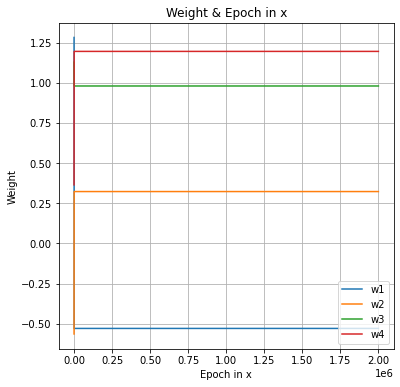

In [79]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Weight & Epoch in x')
ax.set_xlabel('Epoch in x')
ax.set_ylabel('Weight')
ax.plot(w_trace, label = ['w1', 'w2', 'w3', 'w4'])
ax.tick_params(labelsize=10)
ax.legend(fontsize=10)
ax.grid()

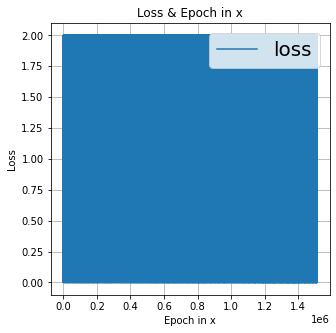

In [80]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Loss & Epoch in x')
ax.set_xlabel('Epoch in x')
ax.set_ylabel('Loss')
ax.plot(loss_trace, label = 'loss')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

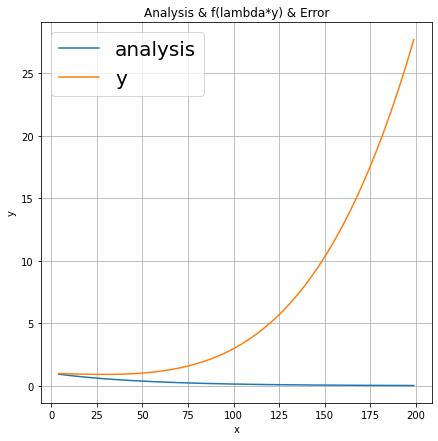

In [81]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, w, n), label = 'y')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

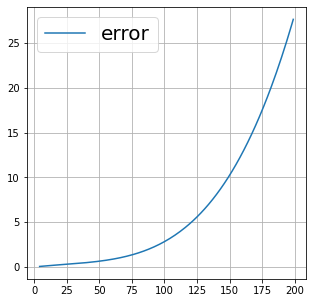

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

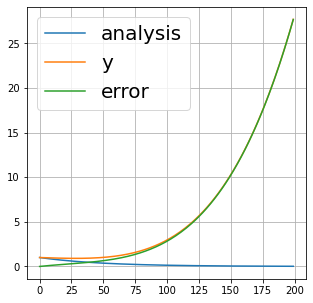

In [83]:
x = tf.Variable([0.01*n for n in range(200)], dtype = tf.float32)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, w, n), label = 'y')
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

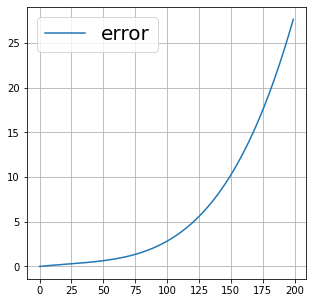

In [84]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [85]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인
# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

In [86]:
print(Epoch)

0
